Convolutions are essential components of any neural networks, image processing, computer vision ... but these are also a bottleneck in terms of computations... I will here benchmark different solutions using ``numpy``, ``scipy`` or ``pytorch``. This is work-in-progress, so that any suggestion is welcome, for instance on [StackExchange](https://dsp.stackexchange.com/questions/43953/looking-for-fastest-2d-convolution-in-python-on-a-cpu) or in the comments below this post.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
#%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
%load_ext autoreload
%autoreload 2


# setting up the problem

The convolution operates on two 2-D matrices. We will here always consider the case which is most typical in computer vision:

 - a first matrix $A$ is the input and is typically large ($N \times N$ where $N$ is typically larger than $2^{10}=1024$),
 - a second matrix $B$ is the template and is typically smaller (say $M=128$),
 - the result of the convolution $C = A \ast B$ is padded such that it is of the same size as $A$.
 
 Often, you need to do that with many images on many kernels. In addition, we will test for the effect of [prefetching]( https://github.com/scikit-image/scikit-image/blob/76fe5a3aba599e7ead9dc1a08b242369c947757b/doc/source/user_guide/numpy_images.rst#notes-on-array-order).
 
 Let's write a small function for this:

In [2]:
N, n_N, M, n_M = 1024, 2, 16, 3
# DEBUG 
# N, n_N, M, n_M = 64, 10, 32, 8

def get_data(N=N, n_N=n_N, M=M, n_M=n_M, seed=42, prefetching=False):
    np.random.seed(seed)
    if prefetching:
        A = np.random.rand(n_N, N, N)
        B = np.random.rand(n_M, M, M)
        C = np.zeros((n_N, n_M, N, N))
    else:
        A = np.random.rand(N, N, n_N)
        B = np.random.rand(M, M, n_M)
        C = np.zeros((N, N, n_N, n_M))
    return A, B, C

for prefetching in [True, False]:
    print ('with prefetching=', prefetching)
    A, B, C = get_data(prefetching=prefetching)
    print('Checking size of A =', A.shape, ' of B=', B.shape, ', and of C=', C.shape)

with prefetching= True
Checking size of A = (2, 1024, 1024)  of B= (3, 16, 16) , and of C= (2, 3, 1024, 1024)
with prefetching= False
Checking size of A = (1024, 1024, 2)  of B= (16, 16, 3) , and of C= (1024, 1024, 2, 3)


The call to this function will generate some initialization time, but makes further tests cleaner:

In [3]:
def test_get_data(N=N, n_N=n_N, M=M, n_M=n_M):
    A, B, C = get_data(N, n_N, M, n_M)  

In [4]:
%%timeit
test_get_data(N, n_N, M, n_M)

28.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# using scipy

The ``scipy`` library as different solutions:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In [5]:
from scipy.signal import convolve2d
def test_scipy(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = convolve2d(A[i_N, :, :], B[i_M, :, :], mode='same', boundary='fill', fillvalue=0)
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = convolve2d(A[:, :, i_N], B[:, :, i_M], mode='same', boundary='fill', fillvalue=0)                

In [6]:
A, B, C = get_data(N, n_N, M, n_M)

In [7]:
%%timeit
test_scipy(A, B, C)

6.12 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [9]:
%%timeit
test_scipy(A, B, C, prefetching=True)

3.4 s ± 52.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
A, B, C = get_data(N, n_N, M, n_M)
from scipy.signal import fftconvolve
def test_scipy_fft(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = fftconvolve(A[i_N, :, :], B[i_M, :, :], mode='same')
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = fftconvolve(A[:, :, i_N], B[:, :, i_M], mode='same')                            

In [11]:
A, B, C = get_data(N, n_N, M, n_M)

In [12]:
%%timeit
test_scipy_fft(A, B, C)

407 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [14]:
%%timeit
test_scipy_fft(A, B, C, prefetching=True)

386 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Fruther profiling, shows that most of the computing time is divided between the three FFT (2 forward, one inverse):

This shows the advantage of using the Fourier transform to perform the convolution. There is also a slight advantage in using prefetching. However, this solution imposes to have periodic bounds for the borders.

# using directly numpy

Instead of loading ``scipy`` (or more reasonably just the subset that loads the fftpack), one can simply use ``numpy`` (see this comment by [FonderPrism](http://disq.us/url?impression=edac85da-e7ec-11e8-a90d-002590853080&thread=6169151214&forum=2777256&url=http%3A%2F%2Fblog.invibe.net%2Fposts%2F2017-09-20-the-fastest-2d-convolution-in-the-world.html%23comment-4194226955%3A2r-QLLbJUDTFTgvUvpSD8uYz2O4&variant=active&experiment=digests&behavior=click&post=4194226955&type=notification.post.moderator&event=email)).

The idea is to simply load the appropriate library which is documented @
https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft2.html :

In [15]:
A, B, C = get_data(N, n_N, M, n_M)
from numpy.fft  import fft2, ifft2
def np_fftconvolve(A, B):
    return np.real(ifft2(fft2(A)*fft2(B, s=A.shape)))


In [16]:
def test_numpy_fft(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = np_fftconvolve(A[i_N, :, :], B[i_M, :, :])
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = np_fftconvolve(A[:, :, i_N], B[:, :, i_M])                            

In [17]:
A, B, C = get_data(N, n_N, M, n_M)

In [18]:
%%timeit
test_numpy_fft(A, B, C)

662 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [20]:
%%timeit
test_numpy_fft(A, B, C, prefetching=True)

636 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Further profiling shows that most of the computing time is divided between the three FFT (2 forward, one inverse).

This shows the advantage of using the Fourier transform to perform the convolution. There is also a slight advantage in using prefetching.

From the design of the protocol, an optimization consists of computing the FFT transforms just once by using in-memory views of the different images and filters.

In [21]:
A, B, C = get_data(N, n_N, M, n_M)
from numpy.fft  import fft2, ifft2
def test_numpy_fft_opt(A, B, prefetching=False):
    if prefetching:
        f_B = np.zeros((B.shape[0], A.shape[-2], A.shape[-1]), dtype=np.complex128)
        for i_M in np.arange(B.shape[0]):
            f_B[i_M, :, :] = fft2(B[i_M, :, :], s=A.shape[-2:])
        
        for i_N in np.arange(A.shape[0]):
            f_A = fft2(A[i_N, :, :])
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = np.real(ifft2(f_A*f_B[i_M, :, :]))
    else:
        f_B = np.zeros((A.shape[0], A.shape[1], B.shape[-1]), dtype=np.complex128)
        for i_M in np.arange(B.shape[-1]):
            f_B[:, :, i_M] = fft2(B[:, :, i_M], s=A.shape[:2])
        
        for i_N in np.arange(A.shape[-1]):
            f_A = fft2(A[:, :, i_N])
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = np.real(ifft2(f_A*f_B[:, :, i_M]))
                

In [22]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=False)

In [23]:
%%timeit
test_numpy_fft_opt(A, B, prefetching=False)

542 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [25]:
%%timeit
test_numpy_fft_opt(A, B, prefetching=True)

505 ms ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# using ndimage

Within ``scipy``, the ``ndimage`` library as different solutions:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.correlate.html

In [26]:
from scipy.ndimage import convolve
# help(convolve)

In [27]:
from scipy.ndimage import convolve
def test_ndimage(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = convolve(A[i_N, :, :], B[i_M, :, :], mode='constant', cval=0)
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = convolve(A[:, :, i_N], B[:, :, i_M], mode='constant', cval=0)                            
                

In [28]:
A, B, C = get_data(N, n_N, M, n_M)

In [29]:
%%timeit
test_ndimage(A, B, C)

1.51 s ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [31]:
%%timeit
test_ndimage(A, B, C, prefetching=True)

1.48 s ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There is also a ``correlate`` function:

In [32]:
%%timeit
from scipy.ndimage import correlate
C = correlate(A, B[::-1, ::-1], mode='constant', cval=0) 

1.5 s ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



# using skimage

The ``skimage`` has recently grown in popularity and includes many advanced computer vision algorithms. This operator is quick (using the Fourier transform), while allowing for many convenient option (mode, boundaries):
https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/template.py

Note: this function computes a normalized *correlation* so that you need to symmetrically invert the template to get the convolution.

In [33]:
from skimage.feature import match_template
def test_skimage(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = match_template(A[i_N, :, :], B[i_M, :, :], pad_input=True, mode='constant', constant_values=0.)
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = match_template(A[:, :, i_N], B[:, :, i_M], pad_input=True, mode='constant', constant_values=0.)                            

In [34]:
A, B, C = get_data(N, n_N, M, n_M)

In [35]:
%%timeit
test_skimage(A, B, C)

764 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [37]:
%%timeit
test_skimage(A, B, C, prefetching=True)

743 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



# using numba

The ``numba`` package allows access to very fast routine:
http://numba.pydata.org/numba-doc/0.15.1/examples.html#filterbank-correlation

In [38]:
#from __future__ import print_function, division, absolute_import
import numpy as np
import numba
#from numba.utils import IS_PY3
from numba.decorators import jit
from numba import double
#from numba import double, jit

nd4type = numba.double[:,:,:,:]
nd3type = numba.double[:,:,:]

@jit(nopython=True)
def nb_get_data(N=N, n_N=n_N, M=M, n_M=n_M, seed=42, prefetching=False):
    np.random.seed(seed)
    if prefetching:
        A = np.random.rand(n_N, N, N)
        B = np.random.rand(n_M, M, M)
        C = np.zeros((n_N, n_M, N, N))
    else:
        A = np.random.rand(N, N, n_N)
        B = np.random.rand(M, M, n_M)
        C = np.zeros((N, N, n_N, n_M))
    return A, B, C

@jit((nd3type, nd3type, nd4type))
def nbcorr_prefetching(imgs, filters, output):
    n_imgs, n_rows, n_cols = imgs.shape
    n_filters, height, width = filters.shape

    for ii in range(n_imgs):
        for rr in range(n_rows - height + 1):
            for cc in range(n_cols - width + 1):
                for hh in range(height):
                    for ww in range(width):
                        for ff in range(n_filters):
                            imgval = imgs[ii, rr + hh, cc + ww]
                            filterval = filters[ff, hh, ww]
                            output[ii, ff, rr, cc] += imgval * filterval
                            
@jit((nd3type, nd3type, nd4type))                            
def nbcorr(imgs, filters, output):
    n_rows, n_cols, n_imgs = imgs.shape
    height, width, n_filters = filters.shape

    for ii in range(n_imgs):
        for rr in range(n_rows - height + 1):
            for cc in range(n_cols - width + 1):
                for hh in range(height):
                    for ww in range(width):
                        for ff in range(n_filters):
                            imgval = imgs[rr + hh, cc + ww, ii]
                            filterval = filters[hh, ww, ff]
                            output[rr, cc, ii, ff] += imgval * filterval
                            
def test_numba(A, B, C, prefetching=False):
    if prefetching:
        nbcorr_prefetching(A, B, C)
    else:
        nbcorr(A, B, C)        

In [39]:
A, B, C = nb_get_data(N, n_N, M, n_M)

In [40]:
%%timeit
test_numba(A, B, C)

1.2 s ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
A, B, C = nb_get_data(N, n_N, M, n_M, prefetching=True)

In [42]:
%%timeit
test_numba(A, B, C, prefetching=True)

1.44 s ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There may be an advantage when processing multiple images at once:

In [43]:
A, B, C = nb_get_data(N=256, n_N=10, M=32, n_M=10)

In [44]:
%%timeit
test_numba(A, B, C)

3.24 s ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
A, B, C = nb_get_data(N=256, n_N=10, M=32, n_M=10, prefetching=True)

In [46]:
%%timeit
test_numba(A, B, C, prefetching=True)

13.4 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)





Seems promising as many ``numpy`` operations are supported : http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html


# using pytorch

The ``pytorch`` package is currently used in deep-learning (DL) architectures, which also often rely on convolutions (for instance in CNNs):

https://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d


A first advantage is that this convolution operator is optimized to handle multiple examples (mini-batches in DL terminology) over multiple filters (channels in DL), such that  there is no loop needed. The ordering of dimensions folloows a similar strategy as when using ``prefetching``: truy to remember ``(B, C, H, W)`` for respectively mini-batches, channels, height, width:

In [47]:
import torch
from torch.nn.functional import conv2d

filters = torch.randn(8, 4, 3, 3)
inputs = torch.randn(10, 4, 5, 5)
out = conv2d(inputs, filters, padding=1)
out.shape

torch.Size([10, 8, 5, 5])

In our benchmark, we have only one channel, but multiple batches:

In [48]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

A = torch.from_numpy(A[:, None, :, :])
B = torch.from_numpy(B[:, None, :, :])
C = torch.from_numpy(C)
A.shape, B.shape, C.shape

(torch.Size([2, 1, 1024, 1024]),
 torch.Size([3, 1, 16, 16]),
 torch.Size([2, 3, 1024, 1024]))

To get a convolution of the same size, it is necessary to pad the filters (as for numpy). Note the padding is symmetric such that the size of the convolution is bigger than that for  numpy for instance:

In [49]:
C = conv2d(A, B, padding=M//2)
A.shape, B.shape, C.shape

(torch.Size([2, 1, 1024, 1024]),
 torch.Size([3, 1, 16, 16]),
 torch.Size([2, 3, 1025, 1025]))

In [50]:
B.shape[-1]

16

In [51]:
def test_torch(A, B, prefetching=False):
    if prefetching:
        A = np.swapaxes(A, 0, -2)        
        B = np.swapaxes(B, 0, -2)        
        A = np.swapaxes(A, 1, -1)        
        B = np.swapaxes(B, 1, -1)        
    A = torch.from_numpy(A[:, None, :, :])
    B = torch.from_numpy(B[:, None, :, :])
    C = conv2d(A, B, padding=B.shape[-1]//2)

In [52]:
A, B, C = get_data(N, n_N, M, n_M)

In [53]:
%%timeit
test_torch(A, B)

1.22 s ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
A, B, C = get_data(N, n_N, M, n_M, prefetching=True)

In [55]:
%%timeit
test_torch(A, B, prefetching=True)

1.22 s ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is faster than ``scipy_fft`` for instance. It is even faster on a GPU, which we do not include in that particular benchmark because it is difficult to compare it to the other methoss where no such solution exist.

# wrapping things up

Now that we have an implementation for each library, it may be worth checking how they scale with respect to the different parameters:

## number of images

This should scale linearly:

In [56]:
from timeit import Timer
reps = 20
sp, sk, nb, pt, npo = [], [], [], [], []
n_Ns = 2**np.arange(6)

for prefetching in [False, True]:
    for n_N_ in n_Ns:
        A, B, C = get_data(N, n_N_, M, n_M, prefetching=prefetching)
        t = Timer(lambda: test_skimage(A, B, C, prefetching=prefetching))
        sk.append(t.timeit(number=reps))
        t = Timer(lambda: test_scipy_fft(A, B, C, prefetching=prefetching))
        sp.append(t.timeit(number=reps))
        t = Timer(lambda: test_numba(A, B, C, prefetching=prefetching))
        nb.append(t.timeit(number=reps))
        t = Timer(lambda: test_torch(A, B, prefetching=prefetching))
        pt.append(t.timeit(number=reps))
        t = Timer(lambda: test_numpy_fft_opt(A, B, prefetching=prefetching))
        npo.append(t.timeit(number=reps))
        

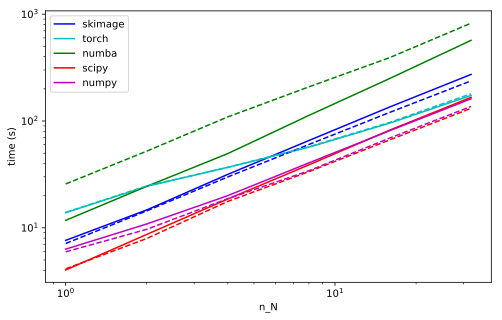

In [57]:
fig , ax = plt.subplots(figsize=(8, 5))
ax.loglog(n_Ns, sk[:len(n_Ns)], c='b', label='skimage')
ax.loglog(n_Ns, pt[:len(n_Ns)], c='c', label='torch')
ax.loglog(n_Ns, nb[:len(n_Ns)], c='g', label='numba')
ax.loglog(n_Ns, sp[:len(n_Ns)], c='r', label='scipy')
ax.loglog(n_Ns, npo[:len(n_Ns)], c='m', label='numpy')
ax.loglog(n_Ns, sk[len(n_Ns):], '--', c='b')
ax.loglog(n_Ns, nb[len(n_Ns):], '--', c='g')
ax.loglog(n_Ns, pt[len(n_Ns):], '--', c='c')
ax.loglog(n_Ns, sp[len(n_Ns):], '--', c='r')
ax.loglog(n_Ns, npo[len(n_Ns):], '--', c='m')
ax.set_xlabel('n_N')
ax.set_ylabel('time (s)')
ax.legend();


## size of images

This should scale supra linearly:

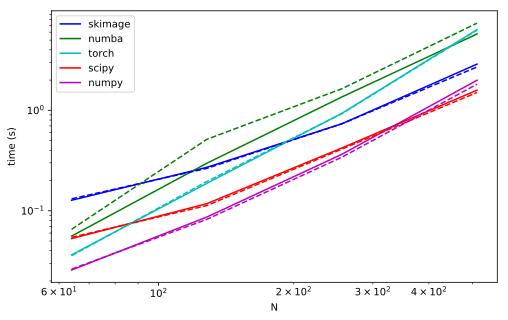

In [58]:
from timeit import Timer
reps = 20
sp, sk, nb, pt, npo = [], [], [], [], []
Ns = 2**np.arange(6, 10)
for prefetching in [False, True]:
    for N_ in Ns:
        A, B, C = get_data(N_, n_N, M, n_M, prefetching=prefetching)
        t = Timer(lambda: test_skimage(A, B, C, prefetching=prefetching))
        sk.append(t.timeit(number=reps))
        t = Timer(lambda: test_scipy_fft(A, B, C, prefetching=prefetching))
        sp.append(t.timeit(number=reps))
        t = Timer(lambda: test_numba(A, B, C, prefetching=prefetching))
        nb.append(t.timeit(number=reps))
        t = Timer(lambda: test_torch(A, B, prefetching=prefetching))
        pt.append(t.timeit(number=reps))
        t = Timer(lambda: test_numpy_fft_opt(A, B, prefetching=prefetching))
        npo.append(t.timeit(number=reps))

fig , ax = plt.subplots(figsize=(8, 5))
ax.loglog(Ns, sk[:len(Ns)], c='b', label='skimage')
ax.loglog(Ns, nb[:len(Ns)], c='g', label='numba')
ax.loglog(Ns, pt[:len(Ns)], c='c', label='torch')
ax.loglog(Ns, sp[:len(Ns)], c='r', label='scipy')
ax.loglog(Ns, npo[:len(Ns)], c='m', label='numpy')
ax.loglog(Ns, sp[len(Ns):], '--', c='r')
ax.loglog(Ns, sk[len(Ns):], '--', c='b')
ax.loglog(Ns, nb[len(Ns):], '--', c='g')
ax.loglog(Ns, pt[len(Ns):], '--', c='c')
ax.loglog(Ns, npo[len(Ns):], '--', c='m')
ax.set_xlabel('N')
ax.set_ylabel('time (s)')
ax.legend();


## number of kernels

This should scale supra linearly:

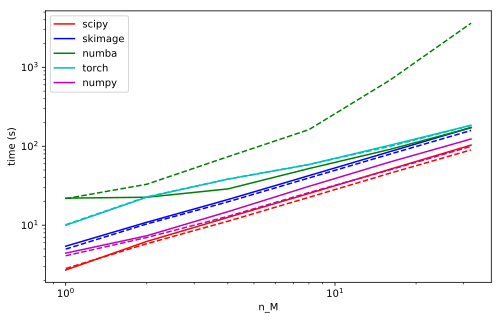

In [59]:
from timeit import Timer
reps = 20
sp, sk, nb, pt, npo = [], [], [], [], []
n_Ms = 2**np.arange(6)

for prefetching in [False, True]:
    for n_M_ in n_Ms:
        A, B, C = get_data(N, n_N, M, n_M_, prefetching=prefetching)
        t = Timer(lambda: test_skimage(A, B, C, prefetching=prefetching))
        sk.append(t.timeit(number=reps))
        t = Timer(lambda: test_scipy_fft(A, B, C, prefetching=prefetching))
        sp.append(t.timeit(number=reps))
        t = Timer(lambda: test_numba(A, B, C, prefetching=prefetching))
        nb.append(t.timeit(number=reps))
        t = Timer(lambda: test_torch(A, B, prefetching=prefetching))
        pt.append(t.timeit(number=reps))        
        t = Timer(lambda: test_numpy_fft_opt(A, B, prefetching=prefetching))
        npo.append(t.timeit(number=reps))
    
fig , ax = plt.subplots(figsize=(8, 5))
ax.loglog(n_Ms, sp[:len(n_Ms)], c='r', label='scipy')
ax.loglog(n_Ms, sk[:len(n_Ms)], c='b', label='skimage')
ax.loglog(n_Ms, nb[:len(n_Ms)], c='g', label='numba')
ax.loglog(n_Ms, pt[:len(n_Ms)], c='c', label='torch')
ax.loglog(n_Ms, npo[:len(n_Ms)], c='m', label='numpy')
ax.loglog(n_Ms, sp[len(n_Ms):], '--', c='r')
ax.loglog(n_Ms, sk[len(n_Ms):], '--', c='b')
ax.loglog(n_Ms, nb[len(n_Ms):], '--', c='g')
ax.loglog(n_Ms, pt[len(n_Ms):], '--', c='c')
ax.loglog(n_Ms, npo[len(n_Ms):], '--', c='m')
ax.set_xlabel('n_M')
ax.set_ylabel('time (s)')
ax.legend();


## size of kernels

This should scale supra linearly:

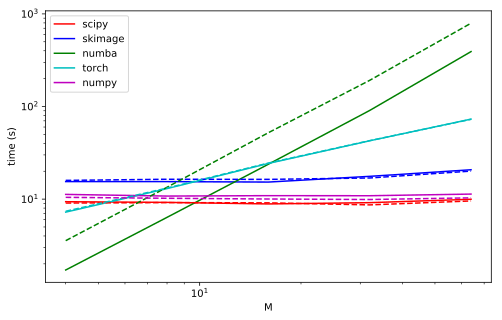

In [60]:
from timeit import Timer
reps = 20
sp, sk, nb, pt, npo = [], [], [], [], []
Ms = 2**np.arange(2, 7)

for prefetching in [False, True]:
    for M_ in Ms:
        A, B, C = get_data(N, n_N, M_, n_M, prefetching=prefetching)
        t = Timer(lambda: test_skimage(A, B, C, prefetching=prefetching))
        sk.append(t.timeit(number=reps))
        t = Timer(lambda: test_scipy_fft(A, B, C, prefetching=prefetching))
        sp.append(t.timeit(number=reps))
        t = Timer(lambda: test_numba(A, B, C, prefetching=prefetching))
        nb.append(t.timeit(number=reps))
        t = Timer(lambda: test_torch(A, B, prefetching=prefetching))
        pt.append(t.timeit(number=reps))        
        t = Timer(lambda: test_numpy_fft_opt(A, B, prefetching=prefetching))
        npo.append(t.timeit(number=reps))
    
fig , ax = plt.subplots(figsize=(8, 5))
ax.loglog(Ms, sp[:len(Ms)], c='r', label='scipy')
ax.loglog(Ms, sk[:len(Ms)], c='b', label='skimage')
ax.loglog(Ms, nb[:len(Ms)], c='g', label='numba')
ax.loglog(Ms, pt[:len(Ms)], c='c', label='torch')
ax.loglog(Ms, npo[:len(Ms)], c='m', label='numpy')
ax.loglog(Ms, sp[len(Ms):], '--', c='r')
ax.loglog(Ms, sk[len(Ms):], '--', c='b')
ax.loglog(Ms, nb[len(Ms):], '--', c='g')
ax.loglog(Ms, pt[len(Ms):], '--', c='c')
ax.loglog(Ms, npo[len(Ms):], '--', c='m')
ax.set_xlabel('M')
ax.set_ylabel('time (s)')
ax.legend();


## conclusion?

As a conclusion, there is not one single answer to all situations, the fastest method will depend on the task at hand. This benchmark needs to be extended to the case where you have access to a GPU for which the parallelization should make convolutions faster with ``pytorch``(in theory). Still, the FFT solution with ``numpy`` seems the most rapid.  Overall, there is also a slight advantage in using prefetching.
In the end, knowing the relative advantage of each library is crucial in the final result.
 


## some book keeping for the notebook

In [61]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, torch, numba

Software versions
Python 3.7.1 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.15.4
scipy 1.2.0
matplotlib 3.0.2
torch 1.0.0
numba 0.41.0
Thu Dec 27 04:01:18 2018 CET